# Informações

Nome: Francisco Altanizio Batista de Castro Junior

Matrícula: 575220

Curso: ENGENHARIA DE TRANSPORTES

Disciplina: CKP8277 - APRENDIZAGEM AUTOMÁTICA

In [1]:
import numpy as np # para operações
import matplotlib.pyplot as plt # para plotagem
import seaborn as sns # para plotagem
import pandas as pd # para algumas poucas manipulações
from scipy.stats import mode 
from itertools import product

In [2]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self,X):
        return X * self.std + self.mean

In [3]:
def calc_acuracia_global(y, y_hat):
    """
    Calcular a acurácia global
    """
    return np.mean(y == y_hat)


def calc_acuracia_classe(y, y_hat):
    """
    Calcular a acurácia por classe
    """
    classes = np.unique(y)
    acuracia_por_classe = {}

    for classe in classes:
        idx_classe = y == classe
        acuracia = np.mean(y_hat[idx_classe] == y[idx_classe])
        acuracia_por_classe[int(classe)] = acuracia

    return acuracia_por_classe


def matriz_confusao(y, y_hat):
    """
    Calcular a matriz de confusão
    """
    classes = np.unique(y)
    n_classes = len(classes)
    matriz = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            matriz[i, j] = np.sum((y == true_class) & (y_hat == pred_class))
    return matriz


def calc_revocacao(y, y_hat):
    """
    Revocação é uma métrica usada em classificação binária para medir
    quantos dos casos positivos reais o modelo conseguiu identificar corretamente
    """
    verdadeiros_positivos = np.sum((y == 1) & (y_hat == 1))
    falsos_negativos = np.sum((y == 1) & (y_hat == 0))
    denominador = verdadeiros_positivos + falsos_negativos
    if denominador == 0:
        return 0.0
    return verdadeiros_positivos / denominador


def calc_precisao(y, y_hat):
    """
    A precisão mede quantas das previsões positivas feitas pelo modelo estavam corretas.
    """
    verdadeiros_positivos = np.sum((y == 1) & (y_hat == 1))
    falsos_positivos = np.sum((y == 0) & (y_hat == 1))
    denominador = verdadeiros_positivos + falsos_positivos
    if denominador == 0:
        return 0.0
    return verdadeiros_positivos / denominador


def calc_f1_score(y, y_hat):
    """
    O F1-score é a média harmônica entre a precisão e a revocação
    """
    verdadeiros_positivos = np.sum((y == 1) & (y_hat == 1))
    falsos_negativos = np.sum((y == 1) & (y_hat == 0))
    falsos_positivos = np.sum((y == 0) & (y_hat == 1))
    denominador = 2 * verdadeiros_positivos + falsos_negativos + falsos_positivos
    if denominador == 0:
        return 0.0
    return 2 * verdadeiros_positivos / denominador

In [4]:
class GridSearchCV:
    """
    kfold: Número de folds para a validação cruzada.
    seed: Valor da semente para garantir reprodutibilidade dos resultados.
    standard: Indica se as variáveis devem ser padronizadas (z-score normalization).
    parametros: Dicionário contendo os parâmetros do modelo a serem avaliados no Grid Search.
    
    O melhor modelo é selecionado pela acurácia.
    """
    def __init__(self, modelo, kfold=10, seed=None, standard=True, parametros = {}):
        self.modelo = modelo
        self.parametros = parametros
        self.kfold = kfold
        self.seed = seed
        self.acuracia = []
        self.standard = standard

    def fit(self, X, y):
        self.acuracia = []
        random_generator = np.random.default_rng(seed=self.seed)
        size_sample = int(len(X) / self.kfold)
        indexes = np.arange(len(X))
        random_generator.shuffle(indexes)
        
        chaves = list(self.parametros.keys())
        valores = list(self.parametros.values())
        
        combinacoes = [dict(zip(chaves, v)) for v in product(*valores)] # Todas as combinações possíveis de parâmetros
        
        for parametro in combinacoes:
            inter_acuracia = []
            for i in range(self.kfold):
                test_indexes = indexes[i * size_sample : (i + 1) * size_sample]
                train_indexes = np.concatenate(
                    (indexes[: i * size_sample], indexes[(i + 1) * size_sample :])
                )
                if self.standard:
                    X_std = StandardScaler()
                    X_train = X_std.fit_transform(X[train_indexes])
                else:
                    X_train = X[train_indexes]

                fit_model = self.modelo(**parametro)

                fit_model.fit(X_train, y[train_indexes])

                if self.standard:
                    X_test = X_std.transform(X[test_indexes])
                else:
                    X_test = X[test_indexes]

                y_test_hat = fit_model.predict(X_test)
                acuracia = calc_acuracia_global(y[test_indexes], y_test_hat)

                inter_acuracia.append(acuracia)

            self.acuracia.append({'parametros': parametro, 'acuracia': acuracia.mean()})        
            
    def best_param(self):
        return max(self.acuracia, key=lambda x: x['acuracia'])['parametros']
    
    def best_model(self):
        return self.modelo(**self.best_param())

In [5]:
class NestedCrossValidation:
    """
    Implementa validação cruzada aninhada com busca em grade (GridSearchCV).
    GridSearchCV: Objeto GridSearchCV utilizado para estimar os melhores hiperparâmetros no nível interno
    kfold: Número de folds para a validação cruzada externa.
    seed: Valor da semente para garantir reprodutibilidade dos resultados.
    standard: Indica se as variáveis devem ser padronizadas (z-score normalization). 
    
    O modelo final (best_model) é selecionado com base na maior acurácia obtida entre os folds da validação cruzada externa.
    """

    def __init__(self, GridSearchCV, kfold=10, seed=None, standard=True):
        self.GridSearchCV = GridSearchCV
        self.kfold = kfold
        self.seed = seed
        self.acuracia = []
        self.acuracia_classe = []
        self.standard = standard
        self.best_model = None

    def fit(self, X, y):
        self.acuracia = []
        self.acuracia_classe = []
        random_generator = np.random.default_rng(seed=self.seed)
        size_sample = int(len(X) / self.kfold)
        indexes = np.arange(len(X))
        random_generator.shuffle(indexes)
        aux_best_model = 0
        for i in range(self.kfold):
            test_indexes = indexes[i * size_sample : (i + 1) * size_sample]
            train_indexes = np.concatenate(
                (indexes[: i * size_sample], indexes[(i + 1) * size_sample :])
            )
            if self.standard:
                X_std = StandardScaler()
                X_train = X_std.fit_transform(X[train_indexes])
            else:
                X_train = X[train_indexes]

            gs_model = self.GridSearchCV

            gs_model.fit(X_train, y[train_indexes])

            best_model = gs_model.best_model()

            best_model.fit(X_train, y[train_indexes])

            print(f"k = {i + 1}/{self.kfold}")
            print(f"Parametros: {gs_model.best_param()}")

            if self.standard:
                X_test = X_std.transform(X[test_indexes])
            else:
                X_test = X[test_indexes]

            y_test_hat = best_model.predict(X_test)
            acuracia = calc_acuracia_global(y[test_indexes], y_test_hat)
            acuracia_classe = calc_acuracia_classe(y[test_indexes], y_test_hat)
            matriz_conf = matriz_confusao(y[test_indexes], y_test_hat)

            print("Matriz de confusão:")
            print(matriz_conf)
            print(f"Acurácia: {acuracia}")
            print(f"Acurácia classe: {acuracia_classe}")

            if acuracia > aux_best_model:
                aux_best_model = acuracia
                self.best_model = best_model

            print(
                "------------------------------------------------------------------------------------------------------"
            )

            self.acuracia.append(acuracia)
            self.acuracia_classe.append(acuracia_classe)

        self.acuracia_classe = {
            classe: [k[classe] for k in self.acuracia_classe]
            for classe in self.acuracia_classe[0]
        }

        print("Melhor modelo: ", self.best_model)

    def summary(self):
        print("------------------------------------------------------------")
        print(
            f"Acurácia - Média: {np.mean(self.acuracia):0.3f} | DP: {np.std(self.acuracia, ddof=1):0.3f}"
        )
        print("Acurácia por classe:")
        classes_media = {
            classe: np.mean(value) for classe, value in self.acuracia_classe.items()
        }
        classes_dp = {
            classe: np.std(value, ddof=1)
            for classe, value in self.acuracia_classe.items()
        }
        for classe in classes_media.keys():
            print(
                f"   - {classe} - Média: {classes_media[classe]:0.3f} | DP: {classes_dp[classe]:0.3f}"
            )
        print("------------------------------------------------------------")

# Questão 1

Considere o conjunto de dados disponível em `californiabin.csv`, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos são usados na predição de preços de casas em distritos da Califórnia na década de 1990. A saída é binária: **0**, para abaixo da mediana dos preços; **1**, para acima da mediana dos preços. Maiores detalhes sobre os dados podem ser conferidos em:  
[https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

## a) Considerando uma divisão de **80% dos padrões para treinamento e 20% para teste**, avalie modelos de **classificação binária** nos dados em questão. Para tanto, use as abordagens abaixo:

- **SVM**: Escolha um *kernel* RBF e use *grid-search* para ajustar os hiperparâmetros `C` (valores `2−5, 2−3, 2−1, ..., 2^11, 2^13, 2^15`) e `γ` (valores `2−15, 2−13, 2−11, ..., 2^1, 2^2, 2^3`).

- **Random Forest**: Use *grid-search* para ajustar o número de classificadores base (valores `10, 20, ..., 180, 190, 200`) e a **máxima profundidade** (*max depth*, valores `4, 6, 8, 10` ou máxima (`None` no sklearn)).



### Leitura dos dados e split

In [6]:
data = np.genfromtxt('californiabin.csv', delimiter=',')

In [7]:
data

array([[   4.1685    ,   20.        ,    6.70063694, ...,   38.8       ,
        -121.15      ,    1.        ],
       [   2.8194    ,   24.        ,    4.7625    , ...,   36.75      ,
        -119.85      ,    0.        ],
       [   2.425     ,   46.        ,    4.92771084, ...,   36.33      ,
        -119.31      ,    0.        ],
       ...,
       [   6.8787    ,   38.        ,    6.12520325, ...,   37.52      ,
        -122.29      ,    1.        ],
       [   7.9761    ,   52.        ,    7.7097561 , ...,   37.8       ,
        -122.44      ,    1.        ],
       [   4.5893    ,   52.        ,    6.27371274, ...,   37.89      ,
        -122.28      ,    1.        ]], shape=(2000, 9))

In [8]:
data.shape

(2000, 9)

In [9]:
X = data[:,0:8]

In [10]:
y = data[:,8]

In [11]:
X.shape

(2000, 8)

In [12]:
y.shape

(2000,)

In [13]:
classes, counts = np.unique(y, return_counts=True)
{int(key): value for key, value in zip(classes, counts / np.sum(counts))}

{0: np.float64(0.5), 1: np.float64(0.5)}

In [14]:
from sklearn.model_selection import train_test_split # eu não usei o que eu fiz, pois achei melhor usar um que tem stratify

In [15]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

### SVC

In [16]:
from sklearn.svm import SVC

In [17]:
GridSearchCV?

Init signature: GridSearchCV(modelo, kfold=10, seed=None, standard=True, parametros={})
Docstring:     
kfold: Número de folds para a validação cruzada.
seed: Valor da semente para garantir reprodutibilidade dos resultados.
standard: Indica se as variáveis devem ser padronizadas (z-score normalization).
parametros: Dicionário contendo os parâmetros do modelo a serem avaliados no Grid Search.

O melhor modelo é selecionado pela acurácia.
Type:           type
Subclasses:     

In [18]:
NestedCrossValidation?

Init signature: NestedCrossValidation(GridSearchCV, kfold=10, seed=None, standard=True)
Docstring:     
Implementa validação cruzada aninhada com busca em grade (GridSearchCV).
GridSearchCV: Objeto GridSearchCV utilizado para estimar os melhores hiperparâmetros no nível interno
kfold: Número de folds para a validação cruzada externa.
seed: Valor da semente para garantir reprodutibilidade dos resultados.
standard: Indica se as variáveis devem ser padronizadas (z-score normalization). 

O modelo final (best_model) é selecionado com base na maior acurácia obtida entre os folds da validação cruzada externa.
Type:           type
Subclasses:     

In [162]:
grid_svc = GridSearchCV(
    SVC,
    parametros={
        "random_state": [1],
        "kernel": ['rbf'],
        "C": [2**i for i in range(-5, 16, 2)],
        "gamma": [2**i for i in range(-15, 4, 2)],
    },
    kfold=10,
    seed=1,
)

In [ ]:
nest_svc = NestedCrossValidation(grid_svc, kfold=5, seed=1) # kfold - 5 externo e 10 internos | Variáveis padronizadas por padrão

In [164]:
nest_svc.fit(X_train_validation,y_train_validation)

k = 1/5
Parametros: {'random_state': 1, 'kernel': 'rbf', 'C': 8, 'gamma': 0.5}
Matriz de confusão:
[[128  25]
 [ 29 138]]
Acurácia: 0.83125
Acurácia classe: {0: np.float64(0.8366013071895425), 1: np.float64(0.8263473053892215)}
------------------------------------------------------------------------------------------------------
k = 2/5
Parametros: {'random_state': 1, 'kernel': 'rbf', 'C': 32, 'gamma': 0.125}
Matriz de confusão:
[[136  20]
 [ 21 143]]
Acurácia: 0.871875
Acurácia classe: {0: np.float64(0.8717948717948718), 1: np.float64(0.8719512195121951)}
------------------------------------------------------------------------------------------------------
k = 3/5
Parametros: {'random_state': 1, 'kernel': 'rbf', 'C': 128, 'gamma': 0.125}
Matriz de confusão:
[[140  31]
 [ 21 128]]
Acurácia: 0.8375
Acurácia classe: {0: np.float64(0.8187134502923976), 1: np.float64(0.8590604026845637)}
------------------------------------------------------------------------------------------------------


In [166]:
best_model_svc = nest_svc.best_model

### RandomForestClassifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
grid_rf = GridSearchCV(
    RandomForestClassifier,
    parametros={
        "random_state": [1],
        "n_estimators": [i for i in range(10, 201, 10)],
        "max_depth": [None, 4, 6, 8, 10],
        "n_jobs": [-1]
    },
    kfold=10,
    seed=1,
    standard=False,
)

In [175]:
nest_rf = NestedCrossValidation(grid_rf, kfold=5, seed=1, standard=False)

In [176]:
nest_rf.fit(X_train_validation,y_train_validation)

k = 1/5
Parametros: {'random_state': 1, 'n_estimators': 20, 'max_depth': None, 'n_jobs': -1}
Matriz de confusão:
[[132  21]
 [ 33 134]]
Acurácia: 0.83125
Acurácia classe: {0: np.float64(0.8627450980392157), 1: np.float64(0.8023952095808383)}
------------------------------------------------------------------------------------------------------
k = 2/5
Parametros: {'random_state': 1, 'n_estimators': 70, 'max_depth': None, 'n_jobs': -1}
Matriz de confusão:
[[134  22]
 [ 26 138]]
Acurácia: 0.85
Acurácia classe: {0: np.float64(0.8589743589743589), 1: np.float64(0.8414634146341463)}
------------------------------------------------------------------------------------------------------
k = 3/5
Parametros: {'random_state': 1, 'n_estimators': 20, 'max_depth': 10, 'n_jobs': -1}
Matriz de confusão:
[[153  18]
 [ 22 127]]
Acurácia: 0.875
Acurácia classe: {0: np.float64(0.8947368421052632), 1: np.float64(0.8523489932885906)}
---------------------------------------------------------------------------

In [178]:
best_model_rf = nest_rf.best_model

### Resultados

In [165]:
nest_svc.summary()

------------------------------------------------------------
Acurácia - Média: 0.840 | DP: 0.018
Acurácia por classe:
   - 0 - Média: 0.839 | DP: 0.020
   - 1 - Média: 0.841 | DP: 0.022
------------------------------------------------------------


In [ ]:
nest_rf.summary() # Melhor modelo

------------------------------------------------------------
Acurácia - Média: 0.851 | DP: 0.019
Acurácia por classe:
   - 0 - Média: 0.867 | DP: 0.021
   - 1 - Média: 0.834 | DP: 0.020
------------------------------------------------------------


## b) Para cada modelo campeão, reporte os **hiperparâmetros selecionados** e as métricas de **acurácia**, **revocação**, **precisão** e **F1-score** nos dados de teste. Plote também a **curva ROC** e a **curva Precision-Recall**, reportando as áreas sob as curvas, i.e., **AUROC** e **AUPRC**.

In [28]:
x_scaler = StandardScaler()
X_train_validation_standard = x_scaler.fit_transform(X_train_validation)

In [29]:
X_test_standard = x_scaler.transform(X_test)

In [ ]:
best_model_svc.fit(X_train_validation_standard, y_train_validation) # Padronizado

SVC(C=32, gamma=0.125, random_state=1)

In [ ]:
best_model_rf.fit(X_train_validation, y_train_validation) # Não padronizado

RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1, random_state=1)

In [1]:
import pickle

In [184]:
models = [best_model_svc, best_model_rf]
with open('models_list.pkl', 'wb') as file:
    pickle.dump(models, file)

In [2]:
# Nota: Professor, eu queria ter implementado do zero as funções a seguir, mas devido a restrições de tempo não consegui
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

In [10]:
with open('models_list.pkl', 'rb') as file:
    loaded_models = pickle.load(file)


Métricas para o melhor modelo: SVC(C=32, gamma=0.125, random_state=1)
Acurácia: 0.8550
Revocação: 0.8550
Precisão: 0.8550
F1 Score: 0.8550
Matriz de confusão:
[[171  29]
 [ 29 171]]

Métricas para o melhor modelo: RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1, random_state=1)
Acurácia: 0.8600
Revocação: 0.8636
Precisão: 0.8550
F1 Score: 0.8593
Matriz de confusão:
[[173  29]
 [ 27 171]]


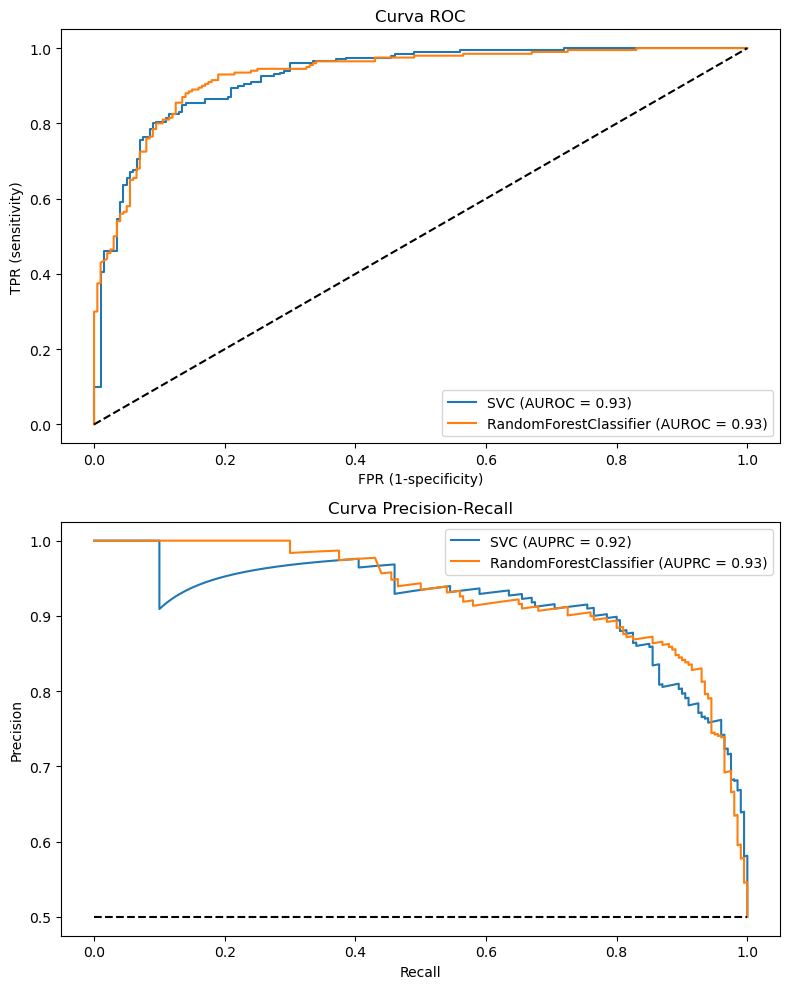

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

for model in loaded_models:
    model_name = model.__class__.__name__
    print(f"\n{'=' * 120}")
    print(f"Métricas para o melhor modelo: {model}")
    print(f"{'=' * 120}")

    if model_name == "SVC":
        y_test_hat = model.predict(X_test_standard)
    else:
        y_test_hat = model.predict(X_test)

    acc = calc_acuracia_global(y_test_hat, y_test)
    rev = calc_revocacao(y_test_hat, y_test)
    prec = calc_precisao(y_test_hat, y_test)
    f1 = calc_f1_score(y_test_hat, y_test)
    matriz_conf = matriz_confusao(y_test_hat, y_test)

    print(f"Acurácia: {acc:.4f}")
    print(f"Revocação: {rev:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Matriz de confusão:")
    print(matriz_conf)

    if model_name == "SVC":
        y_test_score = model.decision_function(X_test_standard)
    else:
        y_test_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = roc_auc_score(y_test, y_test_score)
    ax[0].plot(fpr, tpr, label=f"{model_name} (AUROC = {roc_auc:.2f})")

    precision, recall, _ = precision_recall_curve(y_test, y_test_score)
    avg_precision = average_precision_score(y_test, y_test_score)
    ax[1].plot(recall, precision, label=f"{model_name} (AUPRC = {avg_precision:.2f})")

ax[0].plot([0, 1], [0, 1], "k--")
ax[0].set_xlabel("FPR (1-specificity)")
ax[0].set_ylabel("TPR (sensitivity)")
ax[0].set_title("Curva ROC")
ax[0].legend()

_, counts = np.unique(y_train_validation, return_counts=True)
counts = (counts / np.sum(counts))[1]

ax[1].plot([0, 1], [counts, counts], "k--")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Curva Precision-Recall")
ax[1].legend()

plt.tight_layout()
plt.show()